In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

# Generate Synthetic Data

In [3]:
numSyntheticSamples = 100000
syntheticDataRange = np.linspace( 0, np.pi*numSyntheticSamples/10.0, numSyntheticSamples)
syntheticData = np.sin( syntheticDataRange )

In [4]:
if syntheticData.ndim < 2:
    syntheticData = np.expand_dims(syntheticData, axis=1)

In [5]:
syntheticData.shape

(100000, 1)

<IPython.core.display.Javascript object>


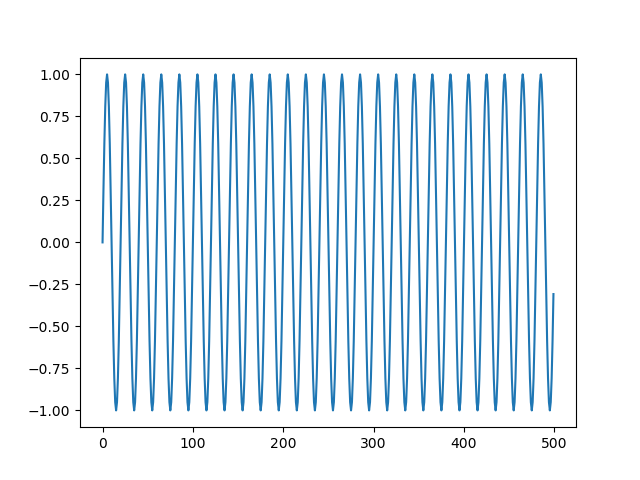

In [6]:
plt.figure()
plt.plot(syntheticData[:500])

# Define hyperparameters

In [7]:
# of samples per sensor for the micro model [sliding window of ~2.5 hrs]
hParams = {}
hParams['windowSamples'] = 30
hParams['nSensors'] = 1
hParams['overlapPercentage'] = .99
hParams['advanceSamples'] = ( hParams['windowSamples'] - int( np.floor( hParams['windowSamples'] * hParams['overlapPercentage'] ) ))

# Split into train and test set (.25 test data)

In [8]:
def train_test_split (x, testDataRatio = .25, trainDataAtStart = True):
    assert x.ndim > 1
    if trainDataAtStart:
        splitIndex = int( ( 1.0 - testDataRatio) * x.shape[0] )    
        
        xTrain = x[ 0:splitIndex, :]
        xTest = x[ splitIndex:, :]
    else:
        splitIndex = int( testDataRatio * x.shape[0] )
        xTest = x[ 0:splitIndex, :]
        xTrain = x[ splitIndex:, :]
        
    return xTrain, xTest

In [9]:
trainSplit, testSplit = train_test_split( syntheticData )

In [10]:
syntheticData.shape

(100000, 1)

In [11]:
trainSplit.shape

(75000, 1)

In [12]:
testSplit.shape

(25000, 1)

# No augmentation / noise injection

# Normalize data ( 0 mean, unit standard deviation )

In [13]:
# find normalization statistics
trainMeans = np.mean(trainSplit, axis=0)
trainSTDevs = np.std(trainSplit, axis=0)
print(trainMeans); print(trainSTDevs)

# normalize [ in place / overwrite ]
normalizedTrainData = (trainSplit - trainMeans) / (trainSTDevs + .0001)
normalizedTestData = (testSplit - trainMeans) / (trainSTDevs + .0001)

[ -3.93309992e-07]
[ 0.70710323]


# Generate shuffled windows

In [14]:
def reshape_into_shuffled_data_windows ( x, windowSize, advanceSamples ):
    nWindows = int( np.floor( (x.shape[0] - windowSize)/(advanceSamples*1.0) ) )
    # shuffle indexes
    shuffledWindowInds = np.arange(nWindows)
    np.random.shuffle(shuffledWindowInds)    
        
    nSensors = x.shape[1]
    outputMatrix = np.zeros((nWindows, windowSize * nSensors))
    
    # update data matrix on a row by row basis (choosing shuffled windows per row)
    for iWindow in range(nWindows):
        startIndex = shuffledWindowInds[iWindow] * advanceSamples
        endIndex = startIndex + windowSize
        
        # flatten/interleave sensor values
        for iSensor in range(nSensors):
            outputMatrix[iWindow, iSensor::nSensors] = x[startIndex:endIndex, iSensor]
    
    return outputMatrix, shuffledWindowInds


<IPython.core.display.Javascript object>


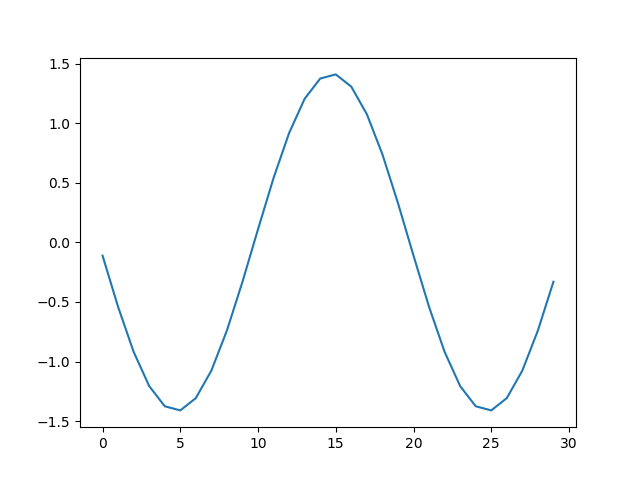

In [15]:
trainMatrix, trainShuffledWindowInds = reshape_into_shuffled_data_windows(normalizedTrainData, hParams['windowSamples'], hParams['advanceSamples'])
testMatrix, testShuffledWindowInds = reshape_into_shuffled_data_windows(normalizedTestData, hParams['windowSamples'], hParams['advanceSamples'])

viz_flag = 1
if viz_flag:
    plt.figure()
    plt.plot(trainMatrix[200,:])


In [ ]:
trainMatrix.shape

In [ ]:
testMatrix.shape

# ML/DL Imports

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense
from keras import metrics
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Model definition

In [23]:
hParams['inputOutputDimensionality'] = int( hParams['windowSamples'] * hParams['nSensors'] ) 
assert hParams['inputOutputDimensionality'] == trainMatrix.shape[1]

# Define model
model = Sequential()
model.add( Dense( 15, input_dim = hParams['inputOutputDimensionality'], activation = 'linear'))
model.add( Dense( 5, activation = 'sigmoid'))
model.add( Dense( 5, activation = 'sigmoid'))
model.add( Dense( 15, activation = 'sigmoid'))
model.add( Dense( hParams['inputOutputDimensionality'], activation = 'linear',))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 80        
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_22 (Dense)             (None, 15)                90        
_________________________________________________________________
dense_23 (Dense)             (None, 30)                480       
Total params: 1,145
Trainable params: 1,145
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>


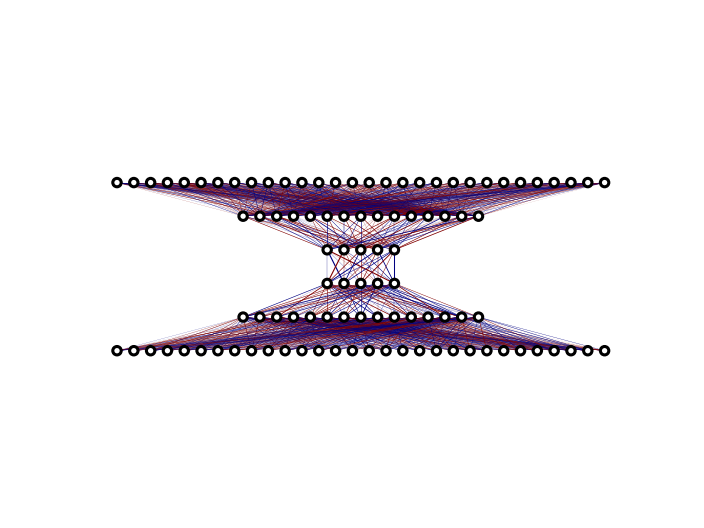

In [24]:
import nnViz
plt.figure()
nnViz.visualize_model(model)

In [25]:
model.compile(optimizer = 'adam', loss = 'mse')

In [26]:
early_stopping = EarlyStopping( monitor = 'val_loss', patience = 10)
checkpointer = ModelCheckpoint( filepath = 'synthetic_sin_weights_2.hdf5', verbose=1, save_best_only = True)

model.fit( trainMatrix,
           trainMatrix,
           batch_size = 256, epochs = 500,
           shuffle = True,
           callbacks = [early_stopping, checkpointer],
           validation_data = (testMatrix, testMatrix) )

Train on 74970 samples, validate on 24970 samples
Epoch 1/500
74970/74970 [==============================] - 2s - loss: 0.9305 - val_loss: 0.7290
Epoch 2/500
74970/74970 [==============================] - 1s - loss: 0.5584 - val_loss: 0.4760
Epoch 3/500
74970/74970 [==============================] - 1s - loss: 0.3237 - val_loss: 0.1008
Epoch 4/500
74970/74970 [==============================] - 1s - loss: 0.0291 - val_loss: 0.0050
Epoch 5/500
74970/74970 [==============================] - 1s - loss: 0.0021 - val_loss: 7.6466e-04
Epoch 6/500
74970/74970 [==============================] - 1s - loss: 4.4037e-04 - val_loss: 2.6588e-04
Epoch 7/500
74970/74970 [==============================] - 1s - loss: 2.0854e-04 - val_loss: 1.6851e-04
Epoch 8/500
74970/74970 [==============================] - 1s - loss: 1.4874e-04 - val_loss: 1.3214e-04
Epoch 9/500
74970/74970 [==============================] - 1s - loss: 1.2074e-04 - val_loss: 1.0891e-04
Epoch 10/500
74970/74970 [========================

74970/74970 [==============================] - 1s - loss: 9.7706e-06 - val_loss: 6.9152e-06
Epoch 32/500
74970/74970 [==============================] - 1s - loss: 6.7200e-06 - val_loss: 7.1396e-06
Epoch 33/500
74970/74970 [==============================] - 1s - loss: 7.3591e-06 - val_loss: 6.4107e-06
Epoch 34/500
74970/74970 [==============================] - 1s - loss: 7.1652e-06 - val_loss: 6.3356e-06
Epoch 35/500
74970/74970 [==============================] - 1s - loss: 6.5631e-06 - val_loss: 4.0082e-06
Epoch 36/500
74970/74970 [==============================] - 1s - loss: 5.0441e-06 - val_loss: 6.4017e-06
Epoch 37/500
74970/74970 [==============================] - 1s - loss: 6.1429e-06 - val_loss: 6.8731e-06
Epoch 38/500
74970/74970 [==============================] - 1s - loss: 5.0132e-06 - val_loss: 1.9739e-05
Epoch 39/500
74970/74970 [==============================] - 1s - loss: 5.0824e-06 - val_loss: 4.3976e-06
Epoch 40/500
74970/74970 [==============================] - 1s - los

# Load best model weights

In [27]:
model.load_weights("synthetic_sin_weights_2.hdf5")
model.compile(optimizer = 'adam', loss = 'mse') # need to recompile model to be able to run prediction

# Plot raw vs predicted 

In [28]:
def windowed_predict(data, windowSize):    
    nWindows = int( data.size / (windowSize*1.0) )
    print('number of windows: ' + str(nWindows))
    predicted = np.zeros((data.shape[0], data.shape[1]))
    
    for iWindow in range(nWindows):
        dataStartIndex = int( iWindow * windowSize )
        dataEndIndex = dataStartIndex + windowSize
        
        predictedWindow = model.predict( np.transpose( data[dataStartIndex:dataEndIndex]) )
        predicted[dataStartIndex:dataEndIndex] = np.transpose(predictedWindow)
        
    return predicted

# Inject Anomalies & Predict

<IPython.core.display.Javascript object>


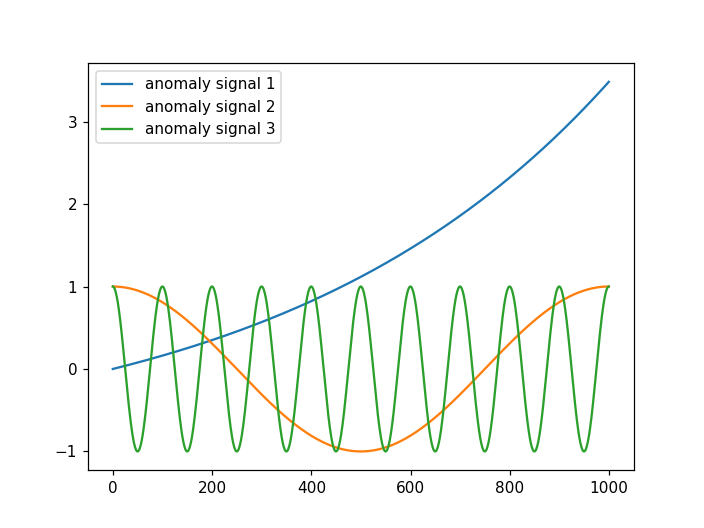

In [29]:
anomalySignal1 = np.exp(np.linspace(0, 1.5, 1000)) - 1
anomalySignal2 = np.cos(np.linspace(0,2*np.pi * 1, 1000))
anomalySignal3 = np.cos(np.linspace(0,2*np.pi * 10, 1000))

anomalySignal1 = np.expand_dims(anomalySignal1, axis=1)
anomalySignal2 = np.expand_dims(anomalySignal2, axis=1)
anomalySignal3 = np.expand_dims(anomalySignal3, axis=1)

plt.figure()
plt.plot(anomalySignal1)
plt.plot(anomalySignal2)
plt.plot(anomalySignal3)
plt.legend(['anomaly signal 1', 'anomaly signal 2', 'anomaly signal 3'])

In [30]:
startIndex = 0
endIndex = 1000
len(anomalySignal1)

1000

In [31]:
targetData = np.concatenate( ( normalizedTestData[startIndex:endIndex], anomalySignal1, \
                               normalizedTestData[startIndex:endIndex], anomalySignal2, \
                               normalizedTestData[startIndex:endIndex], anomalySignal3 ) )

anomalousInds_1 = np.arange(1000/hParams['windowSamples'], 2000/hParams['windowSamples'], dtype=int)
anomalousInds_2 = np.arange(3000/hParams['windowSamples'], 4000/hParams['windowSamples'], dtype=int)
anomalousInds_3 = np.arange(5000/hParams['windowSamples'], 6000/hParams['windowSamples'], dtype=int)

In [32]:
predictedData = windowed_predict ( targetData, hParams['inputOutputDimensionality'])
error = np.sqrt((targetData - predictedData)**2)

number of windows: 200


<IPython.core.display.Javascript object>


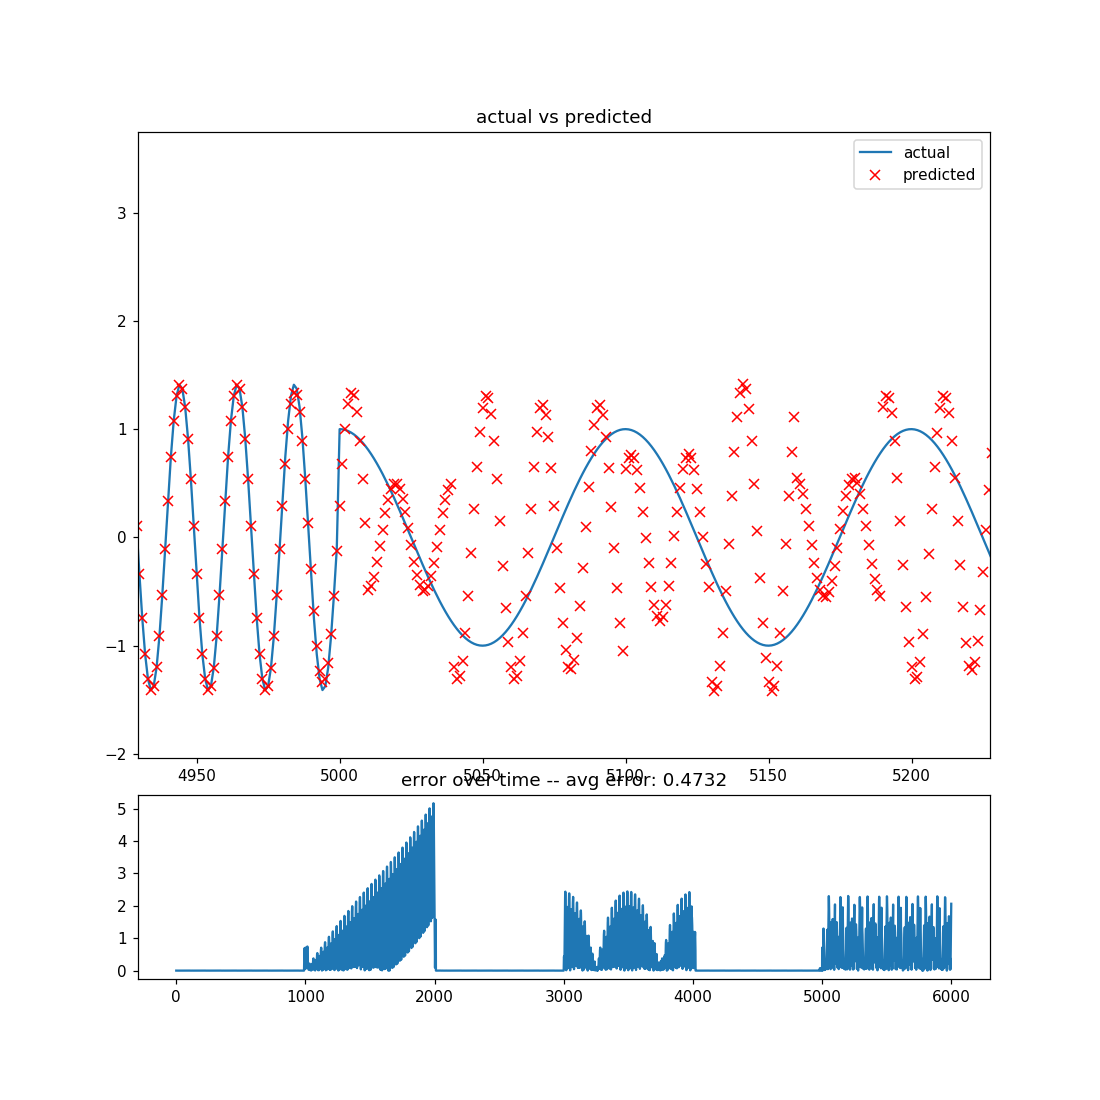

In [33]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)

ax1.plot(targetData)
ax1.plot(predictedData, 'rx')
ax1.set_title('actual vs predicted')
ax1.legend(['actual', 'predicted'])

ax2.plot(error)
#ax2.set_ylim([0,5])
ax2.set_title('error over time -- avg error: ' + str(round(np.mean(error),4)))

## Remove last two layers [ focus on bottleneck activations ]

In [34]:
print(len(model.layers))

5


In [35]:
model.pop()
model.pop()

In [36]:
print(len(model.layers))

3


<IPython.core.display.Javascript object>


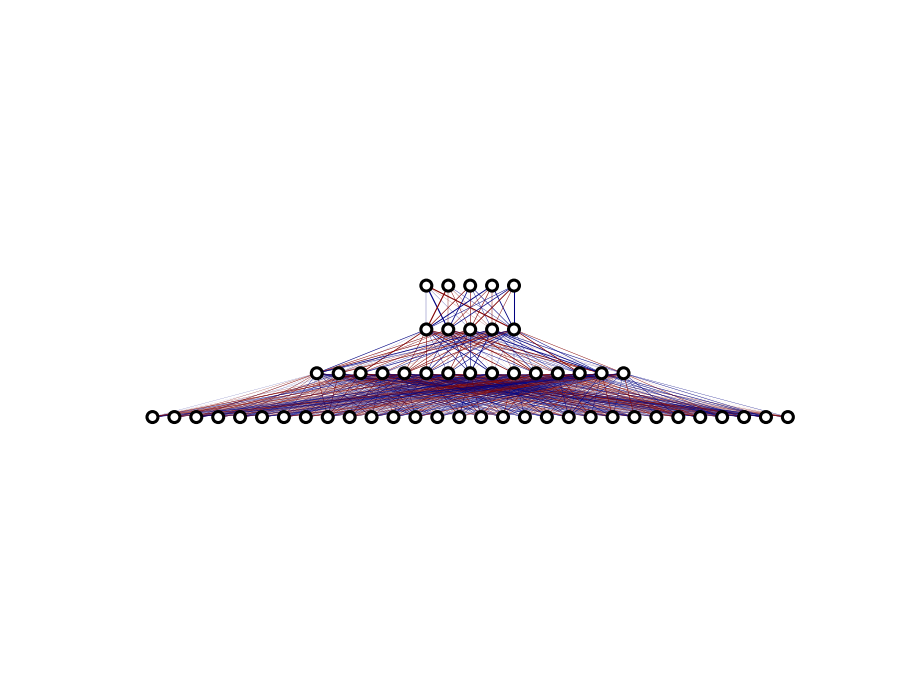

In [37]:
import nnViz
plt.figure()
nnViz.visualize_model(model)

In [38]:
model.compile(optimizer = 'adam', loss = 'mse')

In [39]:
def windowed_predict_bottleneck_activation (data, windowSize, bottleneckSize):    
    nWindows = int( data.size / (windowSize*1.0) )
    print('number of windows: ' + str(nWindows))
    predicted = np.zeros((nWindows, bottleneckSize))
    
    for iWindow in range(nWindows):
        dataStartIndex = int( iWindow * windowSize )
        dataEndIndex = dataStartIndex + windowSize
        
        predictedWindow = model.predict( np.transpose( data[dataStartIndex:dataEndIndex]) )
        predicted[iWindow, :] = predictedWindow[0]
        
        
    return predicted

In [40]:
bottleNeckSize = model.layers[-1].get_config()['units']
bottleneckActivations = windowed_predict_bottleneck_activation (targetData, hParams['inputOutputDimensionality'], bottleNeckSize)

number of windows: 200


In [41]:
from sklearn.manifold import TSNE

embeddedBottleneckActivations = TSNE(n_components = 2, perplexity = 10, learning_rate = 100, method='exact', verbose = 1).fit_transform(bottleneckActivations)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.000190
[t-SNE] KL divergence after 100 iterations with early exaggeration: 10.295210
[t-SNE] Error after 775 iterations: 10.295210


<IPython.core.display.Javascript object>


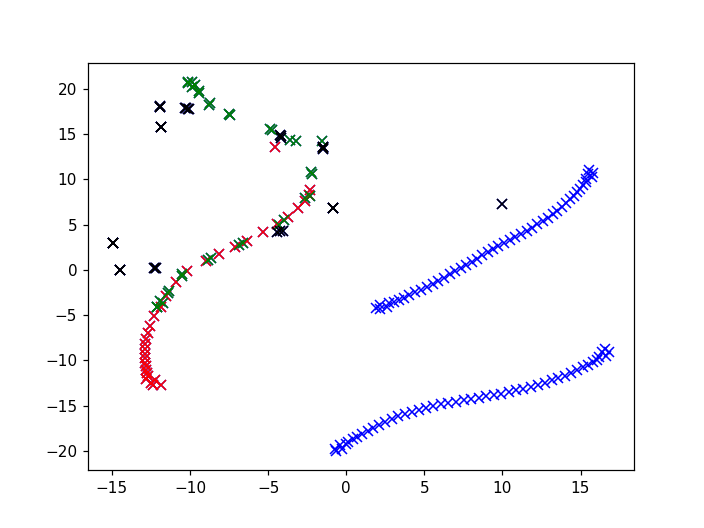

In [42]:
plt.figure()
plt.plot(embeddedBottleneckActivations[:,0], embeddedBottleneckActivations[:,1], 'bx')
plt.plot(embeddedBottleneckActivations[anomalousInds_1,0], embeddedBottleneckActivations[anomalousInds_1,1], 'rx')
plt.plot(embeddedBottleneckActivations[anomalousInds_2,0], embeddedBottleneckActivations[anomalousInds_2,1], 'gx')
plt.plot(embeddedBottleneckActivations[anomalousInds_3,0], embeddedBottleneckActivations[anomalousInds_3,1], 'kx')


In [ ]:
plt.figure()
plt.plot(embeddedBottleneckActivations[:,0], embeddedBottleneckActivations[:,1], 'bx')
plt.plot(embeddedBottleneckActivations[anomalousInds_1,0], embeddedBottleneckActivations[anomalousInds_1,1], 'rx')
plt.plot(embeddedBottleneckActivations[anomalousInds_2,0], embeddedBottleneckActivations[anomalousInds_2,1], 'gx')
plt.plot(embeddedBottleneckActivations[anomalousInds_3,0], embeddedBottleneckActivations[anomalousInds_3,1], 'kx')


In [43]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pca = PCA(n_components=2)
PCA_bottleneckActivations = pca.fit_transform(bottleneckActivations)

<IPython.core.display.Javascript object>


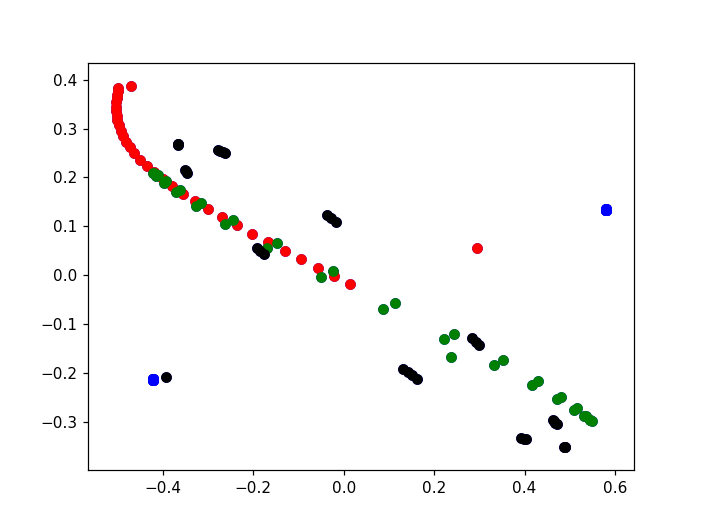

In [44]:
plt.figure()
plt.scatter(PCA_bottleneckActivations[:,0],PCA_bottleneckActivations[:,1], color='b')
plt.scatter(PCA_bottleneckActivations[anomalousInds_1,0],PCA_bottleneckActivations[anomalousInds_1,1], color='r')
plt.scatter(PCA_bottleneckActivations[anomalousInds_2,0],PCA_bottleneckActivations[anomalousInds_2,1], color='g')
plt.scatter(PCA_bottleneckActivations[anomalousInds_3,0],PCA_bottleneckActivations[anomalousInds_3,1], color='k')